<a href="https://colab.research.google.com/github/hsanthan/qiskit-machine-learning/blob/main/mnist_torch_connector_hybrid_qnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 5.2 MB/s 
     |████████████████████████████████| 18.0 MB 228 kB/s 
     |████████████████████████████████| 240 kB 36.2 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 112 kB 58.9 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 38.1 MB 38.6 MB/s 
     |████████████████████████████████| 943 kB 42.8 MB/s 
     |████████████████████████████████| 1.6 MB 47.0 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 4.1 MB 41.8 MB/s 
     |████████████████████████████████| 112 kB 46.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.37.0-py3-none-any.whl size=12028 sha256=de9a7ccc2299629290d76ea8ccb8d0e05e0beed9fe1213a0fbddaa6f71767c0e
  

In [4]:
!pip install qiskit_machine_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 5.0 MB/s 


In [5]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

In [6]:
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [11]:
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

In [7]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



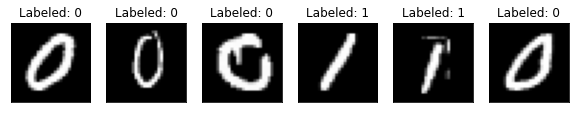

In [8]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1



In [9]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)



In [12]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        2,
        feature_map,
        ansatz,
        input_gradients=True,
        exp_val=AerPauliExpectation(),
        quantum_instance=qi,
    )
    return qnn


qnn4 = create_qnn()
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


In [13]:
# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

In [14]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))



Training [10%]	Loss: -1.1630
Training [20%]	Loss: -1.5294
Training [30%]	Loss: -1.7855
Training [40%]	Loss: -1.9863
Training [50%]	Loss: -2.2257
Training [60%]	Loss: -2.4513
Training [70%]	Loss: -2.6758
Training [80%]	Loss: -2.8832
Training [90%]	Loss: -3.1006
Training [100%]	Loss: -3.3061


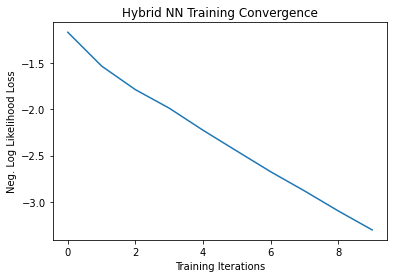

In [15]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [16]:
torch.save(model4.state_dict(), "model4.pt")

In [20]:
model4.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model4(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )



Performance on test data:
	Loss: -3.3585
	Accuracy: 100.0%


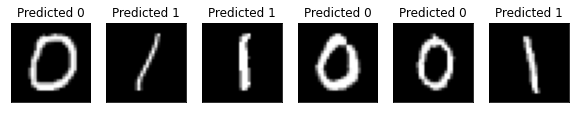

In [21]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model4.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model4(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1